In [2]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


# Load and Explore the Data

In [3]:
df = pd.read_csv('./data/train.csv')

In [4]:
# Display the first few rows of each dataframe to understand their structure
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Printing the Columns

In [5]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

#### Checking Class Balance

In [6]:
df.target.value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
df.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [10]:
df.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [11]:
df.location.unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

#### Imputation of missing values

In [12]:
df["location"] = df["location"].fillna("unknown")

In [13]:
df["keyword"] = df["keyword"].fillna("unknown")

In [14]:
df.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

### Train test-split

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df.target)

In [16]:
train_df.target.value_counts(normalize=True)

target
0    0.570279
1    0.429721
Name: proportion, dtype: float64

In [17]:
test_df.target.value_counts(normalize=True)

target
0    0.570584
1    0.429416
Name: proportion, dtype: float64

 # Text Preprocessing

### Text Preprocessing: The clean_text function cleans the text data by removing URLs, special characters, converting to lowercase, etc., and this is applied to both the training and test datasets.

In [80]:


# Basic preprocessing function to clean the text data
def clean_text(text):
    # Convert text to lower case
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove punctuations including $
    text = text.translate(str.maketrans('', '', string.punctuation + '$'))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    return text

# Apply the clean_text function to both train and test datasets
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Display the first few rows of the cleaned training dataset
print(train_df[['text', 'clean_text']].head())


                                                   text  \
6234  Sassy city girl country hunk stranded in Smoky...   
326   God's Kingdom (Heavenly Gov't) will rule over ...   
997   Mopheme and Bigstar Johnson are a problem in t...   
7269          @VixMeldrew sounds like a whirlwind life!   
2189  Malaysia confirms plane debris washed up on Re...   

                                             clean_text  
6234  sassy city girl country hunk stranded in smoky...  
326   gods kingdom heavenly govt will rule over all ...  
997   mopheme and bigstar johnson are a problem in t...  
7269                       sounds like a whirlwind life  
2189  malaysia confirms plane debris washed up on re...  


# Feature Extraction and Model Training

### Feature Extraction:

    #### TF-IDF Vectorizer: Converts the cleaned text data into numerical features using the TF-IDF (Term Frequency-Inverse Document Frequency) method. This method gives more weight to rare words that may be more significant.

### Model Evaluation:

    Accuracy: The proportion of correctly predicted instances.
    Classification Report: Provides precision, recall, and F1-score for each class, giving a more detailed view of model performance.

In [91]:
 
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
vectorizer.fit(train_df['clean_text'])  # Transform the text data into feature vectors


# Split the data into training and validation sets
X_train, y_train = vectorizer.transform(train_df['clean_text']),train_df['target']
X_test, y_test = vectorizer.transform(test_df['clean_text']),test_df['target']
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the validation set
y_test_pred = model.predict(X_test)

# Evaluate the model's performance on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print(f'Validation Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)




Validation Accuracy: 0.8155
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       869
           1       0.83      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



# Logistic Regression

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=3500)  # Adjust max_features as needed
vectorizer.fit(train_df['clean_text'])  # Transform the text data into feature vectors

# Split the data into training and validation sets
X_train, y_train = vectorizer.transform(train_df['clean_text']), train_df['target']
X_test, y_test = vectorizer.transform(test_df['clean_text']), test_df['target']

# Train a logistic regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')  # You can adjust class_weight as needed
model.fit(X_train, y_train)

# Predict probabilities on the validation set
y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class

# Apply a custom threshold for classification
custom_threshold = 0.6  # Experiment with this value
y_test_pred_custom = (y_test_pred_proba >= custom_threshold).astype(int)

# Evaluate the model's performance using the custom threshold
accuracy_custom = accuracy_score(y_test, y_test_pred_custom)
report_custom = classification_report(y_test, y_test_pred_custom)

print(f'Validation Accuracy with Custom Threshold: {accuracy_custom:.2f}')
print('Classification Report with Custom Threshold:')
print(report_custom)


Validation Accuracy with Custom Threshold: 0.82
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       869
           1       0.87      0.68      0.76       654

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



Validation Accuracy with Custom Threshold: 0.81
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       869
           1       0.87      0.66      0.75       654

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523



# Logistic Regression with smote

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=3500)  # Adjust max_features as needed
vectorizer.fit(train_df['clean_text'])  # Transform the text data into feature vectors

# Split the data into training and validation sets
X_train, y_train = vectorizer.transform(train_df['clean_text']), train_df['target']
X_test, y_test = vectorizer.transform(test_df['clean_text']), test_df['target']

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')  # You can still keep the balanced class_weight
model.fit(X_train_smote, y_train_smote)

# Predict probabilities on the validation set
y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class

# Apply a custom threshold for classification
custom_threshold = 0.6  # Experiment with this value
y_test_pred_custom = (y_test_pred_proba >= custom_threshold).astype(int)

# Evaluate the model's performance using the custom threshold
accuracy_custom = accuracy_score(y_test, y_test_pred_custom)
report_custom = classification_report(y_test, y_test_pred_custom)

print(f'Validation Accuracy with Custom Threshold: {accuracy_custom:.2f}')
print('Classification Report with Custom Threshold:')
print(report_custom)


Validation Accuracy with Custom Threshold: 0.81
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       869
           1       0.86      0.67      0.76       654

    accuracy                           0.81      1523
   macro avg       0.83      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523



# Naive Bayes  with smote

In [149]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=3500)  # Adjust max_features as needed
vectorizer.fit(train_df['clean_text'])  # Fit the vectorizer on the training data

# Transform the text data into feature vectors
X_train, y_train = vectorizer.transform(train_df['clean_text']), train_df['target']
X_test, y_test = vectorizer.transform(test_df['clean_text']), test_df['target']

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Naive Bayes model
model = MultinomialNB()
model.fit(X_train_smote, y_train_smote)

# Predict probabilities on the validation set
y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class

# Apply a custom threshold for classification
custom_threshold = 0.6  # Experiment with this value
y_test_pred_custom = (y_test_pred_proba >= custom_threshold).astype(int)

# Evaluate the model's performance using the custom threshold
accuracy_custom = accuracy_score(y_test, y_test_pred_custom)
report_custom = classification_report(y_test, y_test_pred_custom)

print(f'Validation Accuracy with Custom Threshold: {accuracy_custom:.2f}')
print('Classification Report with Custom Threshold:')
print(report_custom)



Validation Accuracy with Custom Threshold: 0.81
Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       869
           1       0.87      0.66      0.75       654

    accuracy                           0.81      1523
   macro avg       0.83      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523



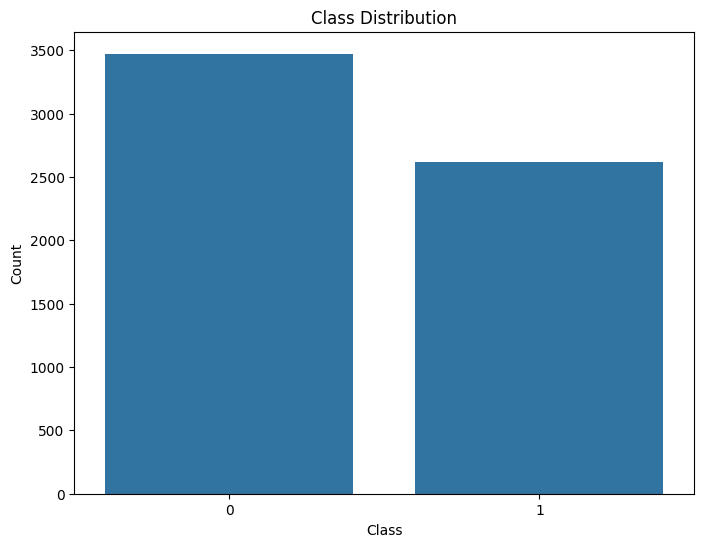

In [150]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Principal Component Analysis

### Data scaling

#### PCA requires scaling/normalization of the data to work properly.

In [92]:

scaler = StandardScaler(with_mean=False)


In [93]:
X_train_scaled = scaler.fit_transform(X_train)

# Work  with  a more robust scaler? 

In [94]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [95]:
df_scaled = pd.DataFrame(data=X_train_scaled, columns=[df.columns[1]])


In [96]:
df_scaled.head()

,keyword
0,<Compressed Sparse Row sparse matrix of dtype ...
1,<Compressed Sparse Row sparse matrix of dtype ...
2,<Compressed Sparse Row sparse matrix of dtype ...
3,<Compressed Sparse Row sparse matrix of dtype ...
4,<Compressed Sparse Row sparse matrix of dtype ...


In [38]:
df_scaled.describe()

c:\Users\serpe\OneDrive\Documentos\Capstone-Project\.venv\Lib\site-packages\pandas\core\algorithms.py:927: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  keys, counts, _ = value_counts_arraylike(values, dropna)


## PCA class import and analysis

In [97]:
pca = PCA(n_components=None)

In [98]:

from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import re

# Assuming df_scaled contains sparse matrices
# Convert each sparse matrix to a dense array and remove the $ symbol
dense_data = []
for row in df_scaled.iloc[:, 0]:  # Assuming the sparse matrices are in the first column
    dense_row = row.toarray()  # Convert to dense array
    
    # Remove the $ symbol and convert to float
    dense_row = np.array([float(re.sub(r'\$', '', str(value))) for value in dense_row[0]])
    dense_data.append(dense_row)

# Convert the list of dense rows to a dense 2D array
dense_data = np.vstack(dense_data)

# Apply PCA
pca = PCA(n_components=2)
df_scaled_pca = pca.fit_transform(dense_data)

print(df_scaled_pca)


[[-0.05994684  0.23111464]
 [-0.01564798 -0.07671734]
 [-0.0343262   0.25997484]
 ...
 [-0.14515712 -0.08800024]
 [-0.12559319 -0.07365823]
 [-0.11986072 -0.09635731]]


In [88]:
print(df_scaled[:5])
print(type(df_scaled))

                                             keyword
0  <Compressed Sparse Row sparse matrix of dtype ...
1  <Compressed Sparse Row sparse matrix of dtype ...
2  <Compressed Sparse Row sparse matrix of dtype ...
3  <Compressed Sparse Row sparse matrix of dtype ...
4  <Compressed Sparse Row sparse matrix of dtype ...
<class 'pandas.core.frame.DataFrame'>


In [100]:
import re
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

# Basic preprocessing function to clean the text data
def clean_text(text):
    # Convert text to lower case
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove punctuations including $
    text = text.translate(str.maketrans('', '', string.punctuation + '$'))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    return text


# Apply the clean_text function to both train and test datasets
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Convert text data to numerical features using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
train_features = vectorizer.fit_transform(train_df['clean_text'])
test_features = vectorizer.transform(test_df['clean_text'])

# Apply MaxAbsScaler
scaler = MaxAbsScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

# Apply PCA
pca = PCA(n_components=100)  # Reduce to 100 dimensions (adjust as necessary)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# The resulting `train_pca` and `test_pca` are the PCA-reduced features you can use for modeling



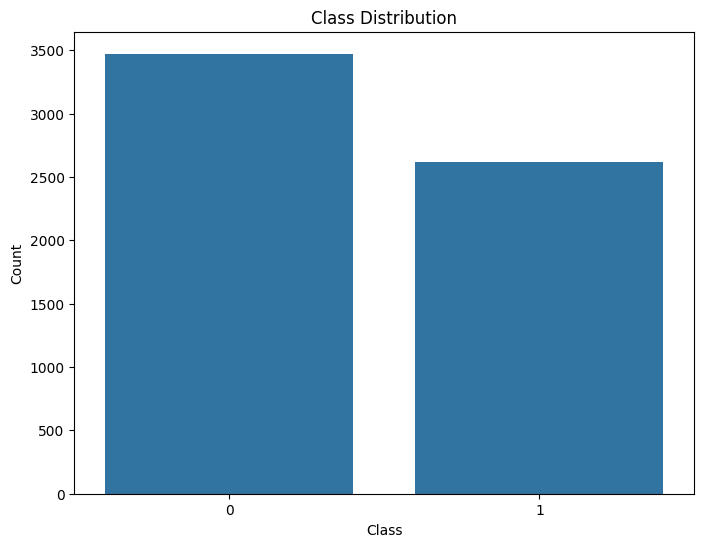

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your target variable is in the 'target' column of train_df
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


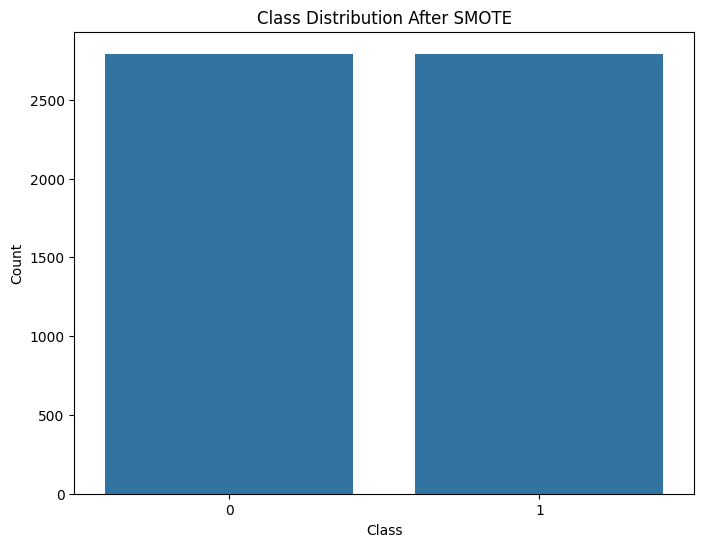

In [102]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming train_pca is the PCA-reduced features and train_df['target'] is your target
X_train, X_val, y_train, y_val = train_test_split(train_pca, train_df['target'], test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Plot class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# Logistic Regression after smote 

Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       681
           1       0.73      0.68      0.70       537

    accuracy                           0.74      1218
   macro avg       0.74      0.74      0.74      1218
weighted avg       0.74      0.74      0.74      1218



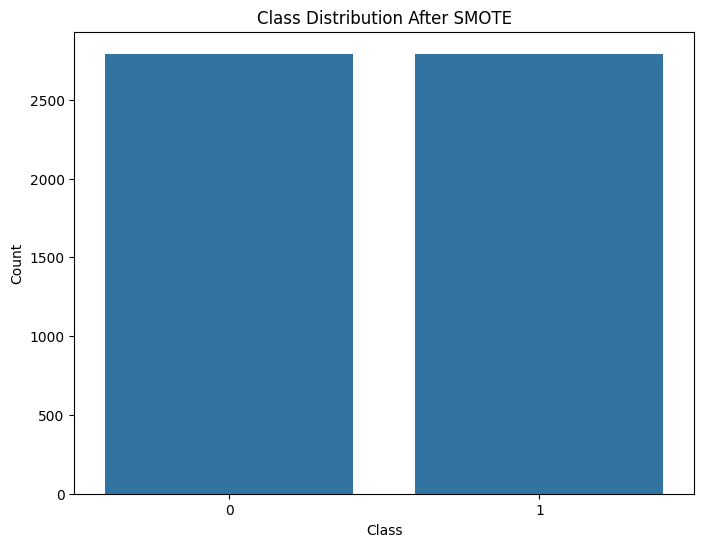

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_pca and train_df['target'] are defined from previous steps
X_train, X_val, y_train, y_val = train_test_split(train_pca, train_df['target'], test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_val, y_pred))

# Plotting class balance after SMOTE (for reference)
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# Random Forest with smote

Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       681
           1       0.75      0.61      0.67       537

    accuracy                           0.74      1218
   macro avg       0.74      0.72      0.73      1218
weighted avg       0.74      0.74      0.73      1218



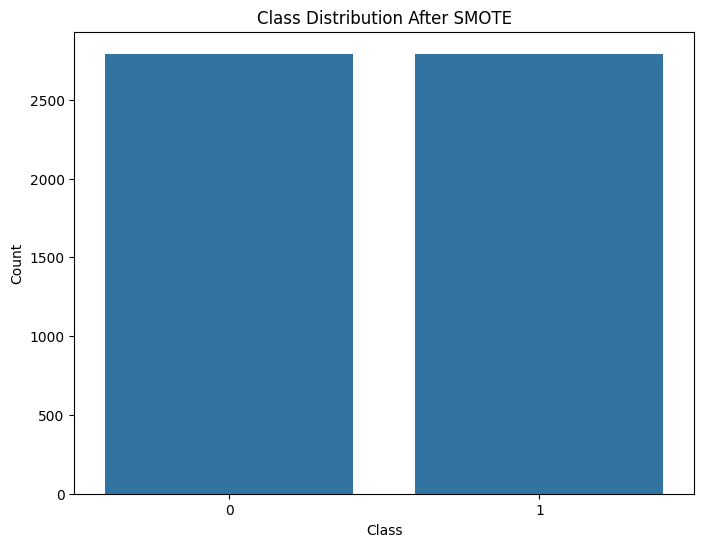

In [104]:
 

# Assuming train_pca and train_df['target'] are defined from previous steps
X_train, X_val, y_train, y_val = train_test_split(train_pca, train_df['target'], test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Logistic Regression model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_val, y_pred))

# Plotting class balance after SMOTE (for reference)
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# SVC with smote

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       681
           1       0.76      0.64      0.69       537

    accuracy                           0.75      1218
   macro avg       0.75      0.74      0.74      1218
weighted avg       0.75      0.75      0.75      1218



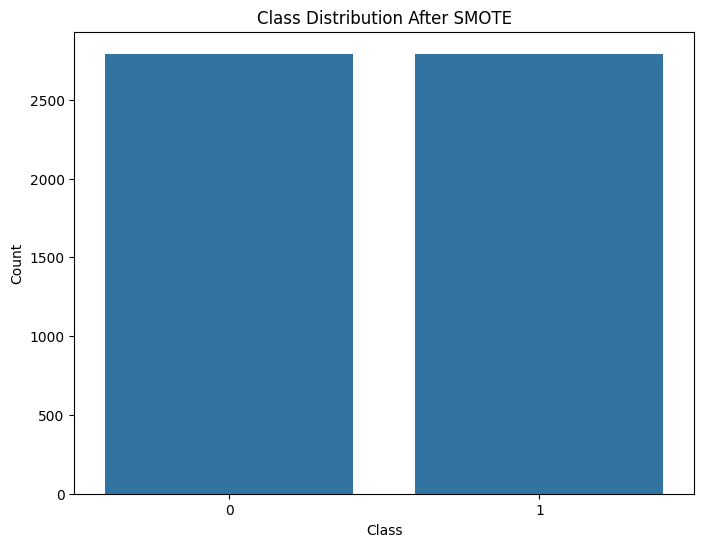

In [108]:
# Assuming train_pca and train_df['target'] are defined from previous steps
X_train, X_val, y_train, y_val = train_test_split(train_pca, train_df['target'], test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Logistic Regression model
model = SVC(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_val, y_pred))

# Plotting class balance after SMOTE (for reference)
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameter tuning for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train_smote, y_train_smote)
best_rf = grid_search.best_estimator_

# Evaluate on validation set
y_pred = best_rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Improved Accuracy: {accuracy:.2f}")

# Detailed classification report
print(classification_report(y_val, y_pred))


Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\serpe\OneDrive\Documentos\Capstone-Project\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Improved Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       681
           1       0.76      0.60      0.67       537

    accuracy                           0.74      1218
   macro avg       0.75      0.73      0.73      1218
weighted avg       0.75      0.74      0.74      1218



In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Set custom class weights
class_weights = {0: 1, 1: 9}  # Adjust according to the imbalance

# Create the model with custom class weights
model = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate the accuracy and other metrics
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print(classification_report(y_val, y_pred))


Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       681
           1       0.75      0.50      0.60       537

    accuracy                           0.71      1218
   macro avg       0.72      0.69      0.69      1218
weighted avg       0.72      0.71      0.70      1218



# Showing better class separation using principal components

### Transform the scaled data set using the fitted PCA object

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score

df = pd.DataFrame('.data/train.csv')

# Encoding categorical features
label_encoder = LabelEncoder()
df['feature2_encoded'] = label_encoder.fit_transform(df['feature2'])

# Splitting the data
X = df[['feature1', 'feature2_encoded']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


ValueError: DataFrame constructor not properly called!

Validation Accuracy: 0.8280
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       869
           1       0.86      0.72      0.78       654

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.83      1523


In [ ]:
X_train.shape

# Predict on the Test Dataset and Prepare Submission

In [ ]:
# Transform the test data using the same TF-IDF vectorizer
X_test = vectorizer.transform(test_df['clean_text'])

# Predict using the trained logistic regression model
test_predictions = model.predict(X_test)

# Prepare the submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_predictions})

# Save the submission to a CSV file
submission_df.to_csv('tweet_disaster_predictions.csv', index=False)

print("Submission file 'tweet_disaster_predictions.csv' has been created.")


### Transform Test Data: The test data is transformed using the same TF-IDF vectorizer that was fitted on the training data.
### Make Predictions: The trained model is used to predict the target (0 or 1) for each tweet in the test dataset.

# Plotting Model Performance

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Confusion Matrix: Provides a visual representation of the model's performance, showing the counts of true positives, true negatives, false positives, and false negatives.

####  ROC Curve: The Receiver Operating Characteristic curve is plotted to evaluate the model's discriminative ability. The area under the curve (AUC) indicates the model's overall performance.

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

# Save the predictions DataFrame as a PDF
with PdfPages('tweet_disaster_predictions.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=submission_df.values, colLabels=submission_df.columns, cellLoc = 'center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    pdf.savefig(fig)
    plt.close(fig)

print("The predictions have been saved as 'tweet_disaster_predictions.pdf'.")


 # Logistic Regression with Hyperparameter Tuning 

In [ ]:
# Hyperparameter tuning for Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
param_grid_logreg = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
grid_logreg = GridSearchCV(log_reg, param_grid_logreg, cv=3, n_jobs=-1, verbose=2)
grid_logreg.fit(X_train, y_train)

# Best model and evaluation
best_logreg = grid_logreg.best_estimator_
y_val_pred_logreg = best_logreg.predict(X_val)
accuracy_logreg = accuracy_score(y_val, y_val_pred_logreg)
print(f'Logistic Regression Validation Accuracy: {accuracy_logreg:.4f}')
print(classification_report(y_val, y_val_pred_logreg))


 # Random Forest with Class Weights

In [ ]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

# Best model and evaluation
best_rf = grid_rf.best_estimator_
y_val_pred_rf = best_rf.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print(f'Random Forest (Balanced) Validation Accuracy: {accuracy_rf:.4f}')
print(classification_report(y_val, y_val_pred_rf))


# Logistic Regression with Class Weights

In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
param_grid_logreg = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
grid_logreg = GridSearchCV(log_reg, param_grid_logreg, cv=3, n_jobs=-1, verbose=2)
grid_logreg.fit(X_train, y_train)

# Best model and evaluation
best_logreg = grid_logreg.best_estimator_
y_val_pred_logreg = best_logreg.predict(X_val)
accuracy_logreg = accuracy_score(y_val, y_val_pred_logreg)
print(f'Logistic Regression (Balanced) Validation Accuracy: {accuracy_logreg:.4f}')
print(classification_report(y_val, y_val_pred_logreg))


# Random Forest with Class Weights

In [ ]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

# Best model and evaluation
best_rf = grid_rf.best_estimator_
y_val_pred_rf = best_rf.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print(f'Random Forest (Balanced) Validation Accuracy: {accuracy_rf:.4f}')
print(classification_report(y_val, y_val_pred_rf))


# Support Vector Machine (SVM) with Class Weights

In [ ]:
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_svm.fit(X_train, y_train)

# Best model and evaluation
best_svm = grid_svm.best_estimator_
y_val_pred_svm = best_svm.predict(X_val)
accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
print(f'SVM (Balanced) Validation Accuracy: {accuracy_svm:.4f}')
print(classification_report(y_val, y_val_pred_svm))


# Voting Classifier with Balanced Models

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', best_logreg),
        ('rf', best_rf),
        ('svm', best_svm)
    ],
    voting='soft'  # Soft voting for probabilistic outcomes
)

voting_clf.fit(X_train, y_train)
y_val_pred_voting = voting_clf.predict(X_val)
accuracy_voting = accuracy_score(y_val, y_val_pred_voting)
print(f'Voting Classifier (Balanced) Validation Accuracy: {accuracy_voting:.4f}')
print(classification_report(y_val, y_val_pred_voting))
